<a href="https://colab.research.google.com/github/Abhi050/DL_Tutorials-PyTorch-/blob/master/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [0]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-2.15                  |              mkl          10 KB  conda-forge
    cpuonly-1.0                |                0           2 KB  pytorch
    freetype-2.10.2            |       he06d7ca_0         905 KB  conda-forge
    intel-openmp-2020.1        |              217         780 KB  defaults
    jpeg-9d                    |       h516909a_0         266 KB  conda-forge
    libblas-3.8.0              |           15_mkl          10 KB  conda-forge
    libcblas-3.8.0             |           1

In [0]:
!pip install pandas --upgrade --quiet

In [0]:
!pip install seaborn --upgrade --quiet

In [0]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [0]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [0]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

103.1%

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [0]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [0]:
your_name = "Abhi050"# at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [0]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [0]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
27,55,female,32.1195,2,no,12759.377540
752,64,male,37.1469,0,no,14778.957388
1258,55,male,36.9607,3,no,31266.123772
384,44,male,21.6923,2,no,8634.637076
406,33,female,23.8238,0,no,4352.501816


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [0]:
num_rows = len(dataframe.index)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [0]:
num_cols =len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [0]:
input_cols = [i for i in dataframe.columns[:-1]]

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [0]:
categorical_cols = [i for i in dataframe.columns if dataframe[i].dtype == 'object']
print(categorical_cols)

['sex', 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [0]:
output_cols = [dataframe.columns[-1]]

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe28998c150>]],
      dtype=object)

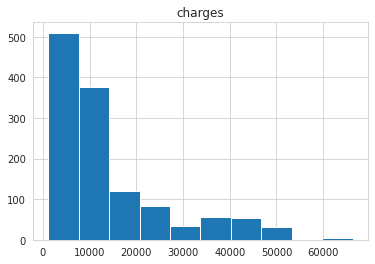

In [0]:
%matplotlib inline
ch_max = dataframe[output_cols].max()
ch_min = dataframe[output_cols].min()
ch_mean = dataframe[output_cols].mean()

import seaborn as sns
sns.set_style('whitegrid')

dataframe[output_cols].hist()

Minimum: 1166.7488560000002
Maximum: 66321.2451304
Average: 13824.97305043443


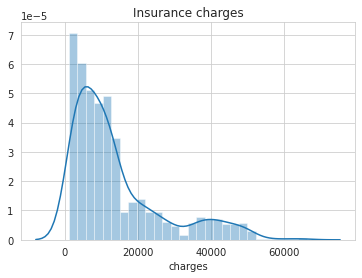

In [0]:
#Inspired from the notebook of "undefined-none"
minimum = dataframe.charges.min()
maximum = dataframe.charges.max()
average = dataframe.charges.mean()


plt.title("Insurance charges")
sns.distplot(dataframe.charges)

print("Minimum: " + str(minimum))
print("Maximum: " + str(maximum))
print("Average: " + str(average))

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [0]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "abhi050/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/abhi050/02-insurance-linear-regression


'https://jovian.ml/abhi050/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [0]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [0]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 32.1195,  2.    ,  0.    ],
        [64.    ,  1.    , 37.1469,  0.    ,  0.    ],
        [55.    ,  1.    , 36.9607,  3.    ,  0.    ],
        ...,
        [56.    ,  1.    , 25.4163,  0.    ,  0.    ],
        [18.    ,  0.    , 29.6989,  0.    ,  0.    ],
        [43.    ,  1.    , 25.5094,  0.    ,  0.    ]]),
 array([[12759.37754 ],
        [14778.957388],
        [31266.123772],
        ...,
        [11612.034356],
        [ 2291.885388],
        [ 7110.863448]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [0]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [0]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [0]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [0]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [0]:
batch_size = 128

In [0]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [0]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[34.0000,  0.0000, 18.6200,  3.0000,  0.0000],
        [21.0000,  1.0000, 21.8540,  1.0000,  0.0000],
        [58.0000,  0.0000, 22.3146,  0.0000,  0.0000],
        [64.0000,  1.0000, 25.0880,  2.0000,  0.0000],
        [61.0000,  1.0000, 30.9386,  0.0000,  0.0000],
        [18.0000,  1.0000, 42.1498,  0.0000,  0.0000],
        [42.0000,  1.0000, 25.5486,  1.0000,  1.0000],
        [20.0000,  0.0000, 32.6340,  0.0000,  0.0000],
        [21.0000,  1.0000, 19.8303,  3.0000,  0.0000],
        [19.0000,  0.0000, 32.2420,  0.0000,  0.0000],
        [46.0000,  0.0000, 27.1656,  1.0000,  0.0000],
        [46.0000,  1.0000, 19.4579,  0.0000,  0.0000],
        [60.0000,  1.0000, 28.3220,  0.0000,  0.0000],
        [60.0000,  1.0000, 30.7230,  3.0000,  1.0000],
        [59.0000,  0.0000, 30.7230,  0.0000,  0.0000],
        [19.0000,  1.0000, 25.0439,  0.0000,  0.0000],
        [45.0000,  1.0000, 35.7504,  2.0000,  1.0000],
        [47.0000,  1.0000, 27.6507,  3.0000,  1.0000],
  

Let's save our work by committing to Jovian.

In [0]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "abhi050/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/abhi050/02-insurance-linear-regression


'https://jovian.ml/abhi050/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [0]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [0]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [0]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [0]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0156, -0.0551, -0.1346, -0.3016, -0.1110]], requires_grad=True),
 Parameter containing:
 tensor([0.4051], requires_grad=True)]

One final commit before we train the model.

In [0]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "abhi050/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/abhi050/02-insurance-linear-regression


'https://jovian.ml/abhi050/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [0]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15079.1708984375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [0]:
e=[50,100,150,200,250,300,500]
l=[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
a=[]
for epochs in e:
    for lr in l:
        h = fit(epochs, lr, model, train_loader, val_loader)
        a.append(h)
        print(h)

Epoch [20], val_loss: 8427.3408
Epoch [40], val_loss: 8406.0977
Epoch [50], val_loss: 8394.9844
[{'val_loss': 8451.2265625}, {'val_loss': 8449.80078125}, {'val_loss': 8448.775390625}, {'val_loss': 8447.19140625}, {'val_loss': 8445.462890625}, {'val_loss': 8444.18359375}, {'val_loss': 8442.78515625}, {'val_loss': 8441.75390625}, {'val_loss': 8440.5849609375}, {'val_loss': 8439.513671875}, {'val_loss': 8438.04296875}, {'val_loss': 8436.82421875}, {'val_loss': 8435.4853515625}, {'val_loss': 8434.123046875}, {'val_loss': 8432.63671875}, {'val_loss': 8431.59765625}, {'val_loss': 8430.568359375}, {'val_loss': 8429.5400390625}, {'val_loss': 8428.400390625}, {'val_loss': 8427.3408203125}, {'val_loss': 8426.076171875}, {'val_loss': 8425.0654296875}, {'val_loss': 8424.013671875}, {'val_loss': 8423.02734375}, {'val_loss': 8421.904296875}, {'val_loss': 8421.091796875}, {'val_loss': 8420.048828125}, {'val_loss': 8418.96875}, {'val_loss': 8418.154296875}, {'val_loss': 8417.49609375}, {'val_loss': 84

Epoch [20], val_loss: 8367.4912
Epoch [40], val_loss: 8346.4844
Epoch [60], val_loss: 8327.8770
Epoch [80], val_loss: 8309.2881
Epoch [100], val_loss: 8290.3418
[{'val_loss': 8387.876953125}, {'val_loss': 8386.845703125}, {'val_loss': 8385.63671875}, {'val_loss': 8384.431640625}, {'val_loss': 8382.8984375}, {'val_loss': 8381.9609375}, {'val_loss': 8380.69140625}, {'val_loss': 8379.599609375}, {'val_loss': 8378.650390625}, {'val_loss': 8377.4541015625}, {'val_loss': 8376.3447265625}, {'val_loss': 8375.38671875}, {'val_loss': 8374.2373046875}, {'val_loss': 8373.486328125}, {'val_loss': 8372.177734375}, {'val_loss': 8371.271484375}, {'val_loss': 8370.369140625}, {'val_loss': 8369.447265625}, {'val_loss': 8368.3984375}, {'val_loss': 8367.4912109375}, {'val_loss': 8366.2080078125}, {'val_loss': 8365.064453125}, {'val_loss': 8364.48046875}, {'val_loss': 8363.62109375}, {'val_loss': 8362.86328125}, {'val_loss': 8361.80859375}, {'val_loss': 8360.423828125}, {'val_loss': 8359.2001953125}, {'val

Epoch [20], val_loss: 8279.9355
Epoch [40], val_loss: 8279.9180
Epoch [60], val_loss: 8279.8984
Epoch [80], val_loss: 8279.8789
Epoch [100], val_loss: 8279.8594
[{'val_loss': 8279.9560546875}, {'val_loss': 8279.955078125}, {'val_loss': 8279.9541015625}, {'val_loss': 8279.953125}, {'val_loss': 8279.951171875}, {'val_loss': 8279.9501953125}, {'val_loss': 8279.94921875}, {'val_loss': 8279.94921875}, {'val_loss': 8279.9482421875}, {'val_loss': 8279.947265625}, {'val_loss': 8279.9453125}, {'val_loss': 8279.9443359375}, {'val_loss': 8279.943359375}, {'val_loss': 8279.94140625}, {'val_loss': 8279.94140625}, {'val_loss': 8279.9404296875}, {'val_loss': 8279.939453125}, {'val_loss': 8279.9375}, {'val_loss': 8279.9375}, {'val_loss': 8279.935546875}, {'val_loss': 8279.935546875}, {'val_loss': 8279.935546875}, {'val_loss': 8279.93359375}, {'val_loss': 8279.9326171875}, {'val_loss': 8279.931640625}, {'val_loss': 8279.9306640625}, {'val_loss': 8279.9296875}, {'val_loss': 8279.9287109375}, {'val_loss'

Epoch [20], val_loss: 8260.7725
Epoch [40], val_loss: 8243.3027
Epoch [60], val_loss: 8226.4873
Epoch [80], val_loss: 8210.4531
Epoch [100], val_loss: 8194.6113
Epoch [120], val_loss: 8179.4883
Epoch [140], val_loss: 8163.1211
Epoch [150], val_loss: 8155.2939
[{'val_loss': 8278.8818359375}, {'val_loss': 8278.146484375}, {'val_loss': 8277.287109375}, {'val_loss': 8276.423828125}, {'val_loss': 8275.466796875}, {'val_loss': 8274.48828125}, {'val_loss': 8273.423828125}, {'val_loss': 8272.181640625}, {'val_loss': 8271.251953125}, {'val_loss': 8270.251953125}, {'val_loss': 8269.39453125}, {'val_loss': 8268.3984375}, {'val_loss': 8267.3408203125}, {'val_loss': 8266.5478515625}, {'val_loss': 8265.681640625}, {'val_loss': 8264.560546875}, {'val_loss': 8263.685546875}, {'val_loss': 8262.66015625}, {'val_loss': 8261.623046875}, {'val_loss': 8260.7724609375}, {'val_loss': 8259.8671875}, {'val_loss': 8258.779296875}, {'val_loss': 8258.015625}, {'val_loss': 8257.177734375}, {'val_loss': 8256.21875},

Epoch [20], val_loss: 8143.1777
Epoch [40], val_loss: 8143.0308
Epoch [60], val_loss: 8142.8818
Epoch [80], val_loss: 8142.7373
Epoch [100], val_loss: 8142.5850
Epoch [120], val_loss: 8142.4355
Epoch [140], val_loss: 8142.2925
Epoch [150], val_loss: 8142.2173
[{'val_loss': 8143.3193359375}, {'val_loss': 8143.3115234375}, {'val_loss': 8143.30517578125}, {'val_loss': 8143.296875}, {'val_loss': 8143.2900390625}, {'val_loss': 8143.28125}, {'val_loss': 8143.2734375}, {'val_loss': 8143.2666015625}, {'val_loss': 8143.2568359375}, {'val_loss': 8143.25}, {'val_loss': 8143.24365234375}, {'val_loss': 8143.236328125}, {'val_loss': 8143.2275390625}, {'val_loss': 8143.2216796875}, {'val_loss': 8143.2138671875}, {'val_loss': 8143.205078125}, {'val_loss': 8143.1982421875}, {'val_loss': 8143.1904296875}, {'val_loss': 8143.1845703125}, {'val_loss': 8143.177734375}, {'val_loss': 8143.169921875}, {'val_loss': 8143.162109375}, {'val_loss': 8143.15478515625}, {'val_loss': 8143.146484375}, {'val_loss': 8143.

Epoch [20], val_loss: 8142.1055
Epoch [40], val_loss: 8142.1050
Epoch [60], val_loss: 8142.1035
Epoch [80], val_loss: 8142.1016
Epoch [100], val_loss: 8142.1006
Epoch [120], val_loss: 8142.1006
Epoch [140], val_loss: 8142.0996
Epoch [150], val_loss: 8142.0986
[{'val_loss': 8142.1064453125}, {'val_loss': 8142.1064453125}, {'val_loss': 8142.1064453125}, {'val_loss': 8142.1064453125}, {'val_loss': 8142.1064453125}, {'val_loss': 8142.10595703125}, {'val_loss': 8142.10595703125}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10595703125}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10595703125}, {'val_loss': 8142.10595703125}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.10546875}, {'val_loss': 8142.1044921875}, {'val_loss': 8142.1044921875}, {'val_loss': 8142.1044921875}, {'val_loss': 8142.1044921875}, {'val_loss

Epoch [20], val_loss: 8128.6387
Epoch [40], val_loss: 8116.5879
Epoch [60], val_loss: 8104.9839
Epoch [80], val_loss: 8093.9180
Epoch [100], val_loss: 8083.3945
Epoch [120], val_loss: 8073.4370
Epoch [140], val_loss: 8063.6045
Epoch [160], val_loss: 8054.3779
Epoch [180], val_loss: 8045.9492
Epoch [200], val_loss: 8039.0439
[{'val_loss': 8141.3427734375}, {'val_loss': 8140.5654296875}, {'val_loss': 8139.8427734375}, {'val_loss': 8139.1494140625}, {'val_loss': 8138.4677734375}, {'val_loss': 8137.7607421875}, {'val_loss': 8137.06884765625}, {'val_loss': 8136.32763671875}, {'val_loss': 8135.6689453125}, {'val_loss': 8135.01171875}, {'val_loss': 8134.384765625}, {'val_loss': 8133.7705078125}, {'val_loss': 8133.1181640625}, {'val_loss': 8132.50244140625}, {'val_loss': 8131.828125}, {'val_loss': 8131.181640625}, {'val_loss': 8130.533203125}, {'val_loss': 8129.8994140625}, {'val_loss': 8129.2646484375}, {'val_loss': 8128.638671875}, {'val_loss': 8128.02783203125}, {'val_loss': 8127.4169921875

Epoch [20], val_loss: 8032.4775
Epoch [40], val_loss: 8032.4121
Epoch [60], val_loss: 8032.3486
Epoch [80], val_loss: 8032.2856
Epoch [100], val_loss: 8032.2227
Epoch [120], val_loss: 8032.1602
Epoch [140], val_loss: 8032.0967
Epoch [160], val_loss: 8032.0322
Epoch [180], val_loss: 8031.9678
Epoch [200], val_loss: 8031.9043
[{'val_loss': 8032.537109375}, {'val_loss': 8032.53515625}, {'val_loss': 8032.53125}, {'val_loss': 8032.52783203125}, {'val_loss': 8032.5244140625}, {'val_loss': 8032.52197265625}, {'val_loss': 8032.51904296875}, {'val_loss': 8032.5146484375}, {'val_loss': 8032.51171875}, {'val_loss': 8032.50830078125}, {'val_loss': 8032.505859375}, {'val_loss': 8032.5029296875}, {'val_loss': 8032.5}, {'val_loss': 8032.49609375}, {'val_loss': 8032.4931640625}, {'val_loss': 8032.490234375}, {'val_loss': 8032.4873046875}, {'val_loss': 8032.4833984375}, {'val_loss': 8032.48046875}, {'val_loss': 8032.4775390625}, {'val_loss': 8032.474609375}, {'val_loss': 8032.470703125}, {'val_loss': 8

Epoch [20], val_loss: 8031.8408
Epoch [40], val_loss: 8031.8398
Epoch [60], val_loss: 8031.8389
Epoch [80], val_loss: 8031.8389
Epoch [100], val_loss: 8031.8379
Epoch [120], val_loss: 8031.8379
Epoch [140], val_loss: 8031.8379
Epoch [160], val_loss: 8031.8374
Epoch [180], val_loss: 8031.8374
Epoch [200], val_loss: 8031.8364
[{'val_loss': 8031.84033203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.83984375}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.83984375}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.83984375}, {'val_loss': 8031.84033203125}, {'val_loss': 8031.84033203125}, {'val_loss': 8031.8408203125}, {'val_loss': 8031.84033203125}, {'val_loss': 8031.839843

Epoch [20], val_loss: 8026.1499
Epoch [40], val_loss: 8021.3027
Epoch [60], val_loss: 8016.7661
Epoch [80], val_loss: 8013.0850
Epoch [100], val_loss: 8010.1274
Epoch [120], val_loss: 8007.4688
Epoch [140], val_loss: 8005.4351
Epoch [160], val_loss: 8003.8877
Epoch [180], val_loss: 8002.3389
Epoch [200], val_loss: 8000.4775
Epoch [220], val_loss: 7999.2930
Epoch [240], val_loss: 7997.6104
Epoch [250], val_loss: 7996.4512
[{'val_loss': 8031.533203125}, {'val_loss': 8031.2216796875}, {'val_loss': 8030.9130859375}, {'val_loss': 8030.5986328125}, {'val_loss': 8030.2998046875}, {'val_loss': 8029.9443359375}, {'val_loss': 8029.6513671875}, {'val_loss': 8029.3154296875}, {'val_loss': 8029.013671875}, {'val_loss': 8028.82080078125}, {'val_loss': 8028.48828125}, {'val_loss': 8028.162109375}, {'val_loss': 8027.916015625}, {'val_loss': 8027.64794921875}, {'val_loss': 8027.3837890625}, {'val_loss': 8027.1279296875}, {'val_loss': 8026.9033203125}, {'val_loss': 8026.64208984375}, {'val_loss': 8026.3

Epoch [120], val_loss: 7995.7949
Epoch [140], val_loss: 7995.7295
Epoch [160], val_loss: 7995.6699
Epoch [180], val_loss: 7995.5518
Epoch [200], val_loss: 7995.6279
Epoch [220], val_loss: 7995.5850
Epoch [240], val_loss: 7995.5996
Epoch [250], val_loss: 7995.5156
[{'val_loss': 7996.4306640625}, {'val_loss': 7996.404296875}, {'val_loss': 7996.37890625}, {'val_loss': 7996.361328125}, {'val_loss': 7996.3486328125}, {'val_loss': 7996.34375}, {'val_loss': 7996.3505859375}, {'val_loss': 7996.32958984375}, {'val_loss': 7996.34912109375}, {'val_loss': 7996.34716796875}, {'val_loss': 7996.3369140625}, {'val_loss': 7996.3369140625}, {'val_loss': 7996.31640625}, {'val_loss': 7996.296875}, {'val_loss': 7996.28125}, {'val_loss': 7996.2548828125}, {'val_loss': 7996.2548828125}, {'val_loss': 7996.2626953125}, {'val_loss': 7996.2333984375}, {'val_loss': 7996.22802734375}, {'val_loss': 7996.2197265625}, {'val_loss': 7996.21435546875}, {'val_loss': 7996.20751953125}, {'val_loss': 7996.208984375}, {'val_

Epoch [240], val_loss: 7995.4326
Epoch [250], val_loss: 7995.4287
[{'val_loss': 7995.5166015625}, {'val_loss': 7995.51513671875}, {'val_loss': 7995.5146484375}, {'val_loss': 7995.51416015625}, {'val_loss': 7995.513671875}, {'val_loss': 7995.5126953125}, {'val_loss': 7995.5126953125}, {'val_loss': 7995.51171875}, {'val_loss': 7995.5126953125}, {'val_loss': 7995.51171875}, {'val_loss': 7995.51025390625}, {'val_loss': 7995.509765625}, {'val_loss': 7995.50634765625}, {'val_loss': 7995.5068359375}, {'val_loss': 7995.5068359375}, {'val_loss': 7995.50537109375}, {'val_loss': 7995.505859375}, {'val_loss': 7995.505859375}, {'val_loss': 7995.509765625}, {'val_loss': 7995.5068359375}, {'val_loss': 7995.50390625}, {'val_loss': 7995.5029296875}, {'val_loss': 7995.5029296875}, {'val_loss': 7995.50390625}, {'val_loss': 7995.50390625}, {'val_loss': 7995.501953125}, {'val_loss': 7995.5}, {'val_loss': 7995.4990234375}, {'val_loss': 7995.4990234375}, {'val_loss': 7995.4970703125}, {'val_loss': 7995.49707

Epoch [20], val_loss: 7995.4263
Epoch [40], val_loss: 7995.4258
Epoch [60], val_loss: 7995.4258
Epoch [80], val_loss: 7995.4258
Epoch [100], val_loss: 7995.4258
Epoch [120], val_loss: 7995.4258
Epoch [140], val_loss: 7995.4258
Epoch [160], val_loss: 7995.4258
Epoch [180], val_loss: 7995.4258
Epoch [200], val_loss: 7995.4248
Epoch [220], val_loss: 7995.4243
Epoch [240], val_loss: 7995.4248
Epoch [250], val_loss: 7995.4248
[{'val_loss': 7995.42578125}, {'val_loss': 7995.42578125}, {'val_loss': 7995.42578125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.4267578125}, {'val_loss': 7995.4267578125}, {'val_loss': 7995.4267578125}, {'val_loss': 7995.4267578125}, {'val_loss': 7995.42626953125}, {'val_loss': 7995.42626953125}, {'val_loss'

Epoch [140], val_loss: 7995.4248
Epoch [160], val_loss: 7995.4248
Epoch [180], val_loss: 7995.4248
Epoch [200], val_loss: 7995.4248
Epoch [220], val_loss: 7995.4248
Epoch [240], val_loss: 7995.4248
Epoch [250], val_loss: 7995.4248
[{'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.4248046875}, {'val_loss': 7995.424804

Epoch [160], val_loss: 7993.7129
Epoch [180], val_loss: 7993.5000
Epoch [200], val_loss: 7993.1001
Epoch [220], val_loss: 7992.8682
Epoch [240], val_loss: 7992.8545
Epoch [260], val_loss: 7992.1714
Epoch [280], val_loss: 7992.7383
Epoch [300], val_loss: 7991.8311
[{'val_loss': 7995.6220703125}, {'val_loss': 7995.50390625}, {'val_loss': 7995.48828125}, {'val_loss': 7995.2705078125}, {'val_loss': 7995.138671875}, {'val_loss': 7995.1318359375}, {'val_loss': 7995.291015625}, {'val_loss': 7995.19482421875}, {'val_loss': 7994.9716796875}, {'val_loss': 7995.1240234375}, {'val_loss': 7995.1845703125}, {'val_loss': 7995.28125}, {'val_loss': 7995.158203125}, {'val_loss': 7995.07763671875}, {'val_loss': 7995.1328125}, {'val_loss': 7994.9921875}, {'val_loss': 7995.09033203125}, {'val_loss': 7995.0439453125}, {'val_loss': 7995.2353515625}, {'val_loss': 7995.173828125}, {'val_loss': 7995.435546875}, {'val_loss': 7995.44970703125}, {'val_loss': 7995.501953125}, {'val_loss': 7995.70458984375}, {'val_l

Epoch [20], val_loss: 7991.9785
Epoch [40], val_loss: 7992.1484
Epoch [60], val_loss: 7992.1567
Epoch [80], val_loss: 7992.2070
Epoch [100], val_loss: 7992.3662
Epoch [120], val_loss: 7992.2979
Epoch [140], val_loss: 7992.3008
Epoch [160], val_loss: 7992.3350
Epoch [180], val_loss: 7992.2788
Epoch [200], val_loss: 7992.3232
Epoch [220], val_loss: 7992.2188
Epoch [240], val_loss: 7992.1958
Epoch [260], val_loss: 7992.1230
Epoch [280], val_loss: 7992.0957
Epoch [300], val_loss: 7992.0107
[{'val_loss': 7991.84912109375}, {'val_loss': 7991.87158203125}, {'val_loss': 7991.890625}, {'val_loss': 7991.8740234375}, {'val_loss': 7991.88720703125}, {'val_loss': 7991.8671875}, {'val_loss': 7991.8642578125}, {'val_loss': 7991.869140625}, {'val_loss': 7991.8818359375}, {'val_loss': 7991.87744140625}, {'val_loss': 7991.89111328125}, {'val_loss': 7991.9326171875}, {'val_loss': 7991.931640625}, {'val_loss': 7991.9384765625}, {'val_loss': 7991.955078125}, {'val_loss': 7991.966796875}, {'val_loss': 7991.

Epoch [20], val_loss: 7992.0186
Epoch [40], val_loss: 7992.0161
Epoch [60], val_loss: 7992.0117
Epoch [80], val_loss: 7992.0117
Epoch [100], val_loss: 7992.0107
Epoch [120], val_loss: 7992.0098
Epoch [140], val_loss: 7992.0127
Epoch [160], val_loss: 7992.0078
Epoch [180], val_loss: 7992.0049
Epoch [200], val_loss: 7992.0107
Epoch [220], val_loss: 7992.0117
Epoch [240], val_loss: 7992.0117
Epoch [260], val_loss: 7992.0010
Epoch [280], val_loss: 7992.0034
Epoch [300], val_loss: 7991.9907
[{'val_loss': 7992.009765625}, {'val_loss': 7992.009765625}, {'val_loss': 7992.0087890625}, {'val_loss': 7992.009765625}, {'val_loss': 7992.00927734375}, {'val_loss': 7992.01220703125}, {'val_loss': 7992.009765625}, {'val_loss': 7992.00830078125}, {'val_loss': 7992.009765625}, {'val_loss': 7992.01171875}, {'val_loss': 7992.01171875}, {'val_loss': 7992.0146484375}, {'val_loss': 7992.015625}, {'val_loss': 7992.0166015625}, {'val_loss': 7992.01806640625}, {'val_loss': 7992.0166015625}, {'val_loss': 7992.018

Epoch [20], val_loss: 7991.9902
Epoch [40], val_loss: 7991.9907
Epoch [60], val_loss: 7991.9907
Epoch [80], val_loss: 7991.9902
Epoch [100], val_loss: 7991.9893
Epoch [120], val_loss: 7991.9902
Epoch [140], val_loss: 7991.9888
Epoch [160], val_loss: 7991.9893
Epoch [180], val_loss: 7991.9902
Epoch [200], val_loss: 7991.9883
Epoch [220], val_loss: 7991.9858
Epoch [240], val_loss: 7991.9863
Epoch [260], val_loss: 7991.9844
Epoch [280], val_loss: 7991.9854
Epoch [300], val_loss: 7991.9854
[{'val_loss': 7991.99169921875}, {'val_loss': 7991.9921875}, {'val_loss': 7991.99169921875}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.9912109375}, {'val_loss': 7991.9912109375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234375}, {'val_loss': 7991.990234

Epoch [20], val_loss: 7991.9844
Epoch [40], val_loss: 7991.9844
Epoch [60], val_loss: 7991.9844
Epoch [80], val_loss: 7991.9849
Epoch [100], val_loss: 7991.9844
Epoch [120], val_loss: 7991.9844
Epoch [140], val_loss: 7991.9844
Epoch [160], val_loss: 7991.9844
Epoch [180], val_loss: 7991.9844
Epoch [200], val_loss: 7991.9844
Epoch [220], val_loss: 7991.9844
Epoch [240], val_loss: 7991.9844
Epoch [260], val_loss: 7991.9844
Epoch [280], val_loss: 7991.9844
Epoch [300], val_loss: 7991.9844
[{'val_loss': 7991.9853515625}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.9853515625}, {'val_loss': 7991.9853515625}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss

Epoch [20], val_loss: 7991.9844
Epoch [40], val_loss: 7991.9844
Epoch [60], val_loss: 7991.9844
Epoch [80], val_loss: 7991.9844
Epoch [100], val_loss: 7991.9844
Epoch [120], val_loss: 7991.9844
Epoch [140], val_loss: 7991.9844
Epoch [160], val_loss: 7991.9844
Epoch [180], val_loss: 7991.9844
Epoch [200], val_loss: 7991.9844
Epoch [220], val_loss: 7991.9844
Epoch [240], val_loss: 7991.9844
Epoch [260], val_loss: 7991.9844
Epoch [280], val_loss: 7991.9844
Epoch [300], val_loss: 7991.9844
[{'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.984375}, {'val_loss': 7991.9843

Epoch [20], val_loss: 7991.9619
Epoch [40], val_loss: 7991.3789
Epoch [60], val_loss: 7991.3750
Epoch [80], val_loss: 7992.2837
Epoch [100], val_loss: 7991.6230
Epoch [120], val_loss: 7991.3955
Epoch [140], val_loss: 7991.7080
Epoch [160], val_loss: 7990.7466
Epoch [180], val_loss: 7990.6650
Epoch [200], val_loss: 7990.3057
Epoch [220], val_loss: 7990.1455
Epoch [240], val_loss: 7990.7041
Epoch [260], val_loss: 7990.7266
Epoch [280], val_loss: 7990.7227
Epoch [300], val_loss: 7989.4053
Epoch [320], val_loss: 7989.8970
Epoch [340], val_loss: 7989.5547
Epoch [360], val_loss: 7989.1680
Epoch [380], val_loss: 7989.5762
Epoch [400], val_loss: 7988.8877
Epoch [420], val_loss: 7989.6494
Epoch [440], val_loss: 7989.6133
Epoch [460], val_loss: 7989.1167
Epoch [480], val_loss: 7988.5532
Epoch [500], val_loss: 7989.1924
[{'val_loss': 7991.7958984375}, {'val_loss': 7991.83984375}, {'val_loss': 7991.92626953125}, {'val_loss': 7991.8837890625}, {'val_loss': 7992.0771484375}, {'val_loss': 7991.748046

Epoch [20], val_loss: 7989.0059
Epoch [40], val_loss: 7988.9062
Epoch [60], val_loss: 7988.8359
Epoch [80], val_loss: 7988.7109
Epoch [100], val_loss: 7988.6021
Epoch [120], val_loss: 7988.4336
Epoch [140], val_loss: 7988.3818
Epoch [160], val_loss: 7988.3804
Epoch [180], val_loss: 7988.4932
Epoch [200], val_loss: 7988.4531
Epoch [220], val_loss: 7988.3853
Epoch [240], val_loss: 7988.2710
Epoch [260], val_loss: 7988.2344
Epoch [280], val_loss: 7988.2275
Epoch [300], val_loss: 7988.2671
Epoch [320], val_loss: 7988.1733
Epoch [340], val_loss: 7988.2944
Epoch [360], val_loss: 7988.2305
Epoch [380], val_loss: 7988.2295
Epoch [400], val_loss: 7988.2720
Epoch [420], val_loss: 7988.4023
Epoch [440], val_loss: 7988.2329
Epoch [460], val_loss: 7988.2095
Epoch [480], val_loss: 7988.1099
Epoch [500], val_loss: 7987.9863
[{'val_loss': 7989.21630859375}, {'val_loss': 7989.1669921875}, {'val_loss': 7989.158203125}, {'val_loss': 7989.15625}, {'val_loss': 7989.1474609375}, {'val_loss': 7989.1318359375

Epoch [40], val_loss: 7987.9849
Epoch [60], val_loss: 7987.9858
Epoch [80], val_loss: 7987.9980
Epoch [100], val_loss: 7988.0078
Epoch [120], val_loss: 7988.0068
Epoch [140], val_loss: 7988.0146
Epoch [160], val_loss: 7988.0225
Epoch [180], val_loss: 7988.0190
Epoch [200], val_loss: 7988.0195
Epoch [220], val_loss: 7988.0283
Epoch [240], val_loss: 7988.0410
Epoch [260], val_loss: 7988.0415
Epoch [280], val_loss: 7988.0264
Epoch [300], val_loss: 7988.0400
Epoch [320], val_loss: 7988.0410
Epoch [340], val_loss: 7988.0405
Epoch [360], val_loss: 7988.0400
Epoch [380], val_loss: 7988.0420
Epoch [400], val_loss: 7988.0381
Epoch [420], val_loss: 7988.0430
Epoch [440], val_loss: 7988.0488
Epoch [460], val_loss: 7988.0337
Epoch [480], val_loss: 7988.0352
Epoch [500], val_loss: 7988.0469
[{'val_loss': 7987.9853515625}, {'val_loss': 7987.986328125}, {'val_loss': 7987.984375}, {'val_loss': 7987.984375}, {'val_loss': 7987.9853515625}, {'val_loss': 7987.986328125}, {'val_loss': 7987.986328125}, {'va

Epoch [20], val_loss: 7988.0459
Epoch [40], val_loss: 7988.0464
Epoch [60], val_loss: 7988.0454
Epoch [80], val_loss: 7988.0449
Epoch [100], val_loss: 7988.0464
Epoch [120], val_loss: 7988.0474
Epoch [140], val_loss: 7988.0479
Epoch [160], val_loss: 7988.0483
Epoch [180], val_loss: 7988.0488
Epoch [200], val_loss: 7988.0503
Epoch [220], val_loss: 7988.0493
Epoch [240], val_loss: 7988.0493
Epoch [260], val_loss: 7988.0479
Epoch [280], val_loss: 7988.0488
Epoch [300], val_loss: 7988.0493
Epoch [320], val_loss: 7988.0488
Epoch [340], val_loss: 7988.0479
Epoch [360], val_loss: 7988.0483
Epoch [380], val_loss: 7988.0498
Epoch [400], val_loss: 7988.0508
Epoch [420], val_loss: 7988.0488
Epoch [440], val_loss: 7988.0518
Epoch [460], val_loss: 7988.0508
Epoch [480], val_loss: 7988.0498
Epoch [500], val_loss: 7988.0508
[{'val_loss': 7988.04638671875}, {'val_loss': 7988.04638671875}, {'val_loss': 7988.0458984375}, {'val_loss': 7988.0458984375}, {'val_loss': 7988.0458984375}, {'val_loss': 7988.045

Epoch [20], val_loss: 7988.0508
Epoch [40], val_loss: 7988.0508
Epoch [60], val_loss: 7988.0508
Epoch [80], val_loss: 7988.0508
Epoch [100], val_loss: 7988.0508
Epoch [120], val_loss: 7988.0513
Epoch [140], val_loss: 7988.0508
Epoch [160], val_loss: 7988.0513
Epoch [180], val_loss: 7988.0508
Epoch [200], val_loss: 7988.0508
Epoch [220], val_loss: 7988.0508
Epoch [240], val_loss: 7988.0508
Epoch [260], val_loss: 7988.0508
Epoch [280], val_loss: 7988.0513
Epoch [300], val_loss: 7988.0513
Epoch [320], val_loss: 7988.0508
Epoch [340], val_loss: 7988.0508
Epoch [360], val_loss: 7988.0508
Epoch [380], val_loss: 7988.0508
Epoch [400], val_loss: 7988.0508
Epoch [420], val_loss: 7988.0508
Epoch [440], val_loss: 7988.0508
Epoch [460], val_loss: 7988.0508
Epoch [480], val_loss: 7988.0508
Epoch [500], val_loss: 7988.0508
[{'val_loss': 7988.05078125}, {'val_loss': 7988.05126953125}, {'val_loss': 7988.05078125}, {'val_loss': 7988.05126953125}, {'val_loss': 7988.05126953125}, {'val_loss': 7988.051269

Epoch [20], val_loss: 7988.0508
Epoch [40], val_loss: 7988.0508
Epoch [60], val_loss: 7988.0508
Epoch [80], val_loss: 7988.0508
Epoch [100], val_loss: 7988.0508
Epoch [120], val_loss: 7988.0508
Epoch [140], val_loss: 7988.0508
Epoch [160], val_loss: 7988.0508
Epoch [180], val_loss: 7988.0508
Epoch [200], val_loss: 7988.0508
Epoch [220], val_loss: 7988.0508
Epoch [240], val_loss: 7988.0508
Epoch [260], val_loss: 7988.0508
Epoch [280], val_loss: 7988.0508
Epoch [300], val_loss: 7988.0508
Epoch [320], val_loss: 7988.0508
Epoch [340], val_loss: 7988.0508
Epoch [360], val_loss: 7988.0508
Epoch [380], val_loss: 7988.0508
Epoch [400], val_loss: 7988.0508
Epoch [420], val_loss: 7988.0508
Epoch [440], val_loss: 7988.0508
Epoch [460], val_loss: 7988.0508
Epoch [480], val_loss: 7988.0508
Epoch [500], val_loss: 7988.0508
[{'val_loss': 7988.05078125}, {'val_loss': 7988.05078125}, {'val_loss': 7988.05078125}, {'val_loss': 7988.05078125}, {'val_loss': 7988.05078125}, {'val_loss': 7988.05078125}, {'va

In [0]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)


Epoch [20], val_loss: 11075.8164
Epoch [40], val_loss: 9181.5977
Epoch [60], val_loss: 8662.1504
Epoch [80], val_loss: 8529.6396
Epoch [100], val_loss: 8473.2852


'\ne=[50,100,150,200,250,300,500]\nl=[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]\nfor epochs in e:\n    for lr in l:\n        h = fit(epochs, lr, model, train_loader, val_loader)\n        print(h)\n'

In [0]:
epochs = 100
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8469.4746
Epoch [40], val_loss: 8465.9443
Epoch [60], val_loss: 8462.5049
Epoch [80], val_loss: 8459.2051
Epoch [100], val_loss: 8456.1533


In [0]:
epochs = 200
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8455.8701
Epoch [40], val_loss: 8455.5684
Epoch [60], val_loss: 8455.2715
Epoch [80], val_loss: 8454.9961
Epoch [100], val_loss: 8454.6914
Epoch [120], val_loss: 8454.3906
Epoch [140], val_loss: 8454.1064
Epoch [160], val_loss: 8453.8105
Epoch [180], val_loss: 8453.4961
Epoch [200], val_loss: 8453.1973


In [0]:
epochs = 300
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8453.1699
Epoch [40], val_loss: 8453.1406
Epoch [60], val_loss: 8453.1123
Epoch [80], val_loss: 8453.0850
Epoch [100], val_loss: 8453.0566
Epoch [120], val_loss: 8453.0273
Epoch [140], val_loss: 8452.9980
Epoch [160], val_loss: 8452.9697
Epoch [180], val_loss: 8452.9395
Epoch [200], val_loss: 8452.9082
Epoch [220], val_loss: 8452.8809
Epoch [240], val_loss: 8452.8506
Epoch [260], val_loss: 8452.8223
Epoch [280], val_loss: 8452.7930
Epoch [300], val_loss: 8452.7617


In [0]:
epochs = 500
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8452.7607
Epoch [40], val_loss: 8452.7598
Epoch [60], val_loss: 8452.7588
Epoch [80], val_loss: 8452.7578
Epoch [100], val_loss: 8452.7559
Epoch [120], val_loss: 8452.7559
Epoch [140], val_loss: 8452.7539
Epoch [160], val_loss: 8452.7529
Epoch [180], val_loss: 8452.7529
Epoch [200], val_loss: 8452.7520
Epoch [220], val_loss: 8452.7520
Epoch [240], val_loss: 8452.7490
Epoch [260], val_loss: 8452.7480
Epoch [280], val_loss: 8452.7471
Epoch [300], val_loss: 8452.7461
Epoch [320], val_loss: 8452.7441
Epoch [340], val_loss: 8452.7432
Epoch [360], val_loss: 8452.7402
Epoch [380], val_loss: 8452.7402
Epoch [400], val_loss: 8452.7402
Epoch [420], val_loss: 8452.7383
Epoch [440], val_loss: 8452.7373
Epoch [460], val_loss: 8452.7354
Epoch [480], val_loss: 8452.7344
Epoch [500], val_loss: 8452.7344


**Q: What is the final validation loss of your model?**

{'val_loss': 8452.734375}


Text(0.5, 1.0, 'Val_loss vs. training epochs')

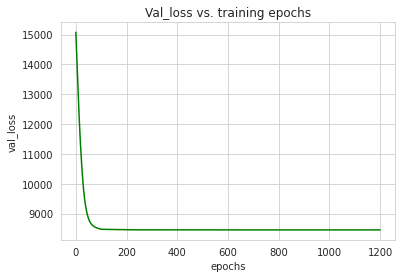

In [0]:
val_loss = evaluate(model, val_loader)
print(val_loss)
val_loss_history = [result] + history1 + history2 + history3 + history4 + history5
val_loss_list = [vl['val_loss'] for vl in val_loss_history]
plt.plot(val_loss_list, '-g')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs. training epochs')
#printing the graph was taken from othe person's notebook on forum, dont remeber the name though

In [0]:
# val_loss = evaluate(model, val_loader)
# print(val_loss)
# val_loss_history = [result] +[i for i in a]
# val_loss_list = [vl['val_loss'] for vl in val_loss_history]
# plt.plot(val_loss_list, '-g')
# plt.xlabel('epochs')
# plt.ylabel('val_loss')
# plt.title('Val_loss vs. training epochs')
#printing the graph was taken from othe person's notebook on forum, dont remeber the name though

Let's log the final validation loss to Jovian and commit the notebook

In [0]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [0]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "abhi050/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/abhi050/02-insurance-linear-regression


'https://jovian.ml/abhi050/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [0]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [0]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([31.0000,  0.0000, 28.6748,  1.0000,  0.0000])
Target: tensor([4524.5352])
Prediction: tensor(5797.0928)


In [0]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([18.0000,  0.0000, 21.2268,  0.0000,  1.0000])
Target: tensor([14854.7979])
Prediction: tensor(2977.0378)


In [0]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([61.0000,  0.0000, 43.1200,  0.0000,  0.0000])
Target: tensor([13586.4385])
Prediction: tensor(12483.5000)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [0]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "abhi050/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/abhi050/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
